In [180]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import pandas as pd
from operator import itemgetter
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=8)

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Regression

## Table Of Content: <a id='toc'></a>

* [Introduction](#intro)

* [Data exploration](#Exploration)


* [Linear regression](#Linear-Regression)

    * [ML approach to linear regression - diabetes data](#LR-1)
    * [Adding regularization to the linear regression](#LR-regul)
    
* [KNN](#KNN)




* [Random Forest](#rf-r)



* [Exercise](#exo)

* [Appendices](#APPENDIX)

    * [SVM](#SVM)
    * [Gradient Boosting](#Gradient)


# Introduction : re-framing the target <a id='intro'></a>

In that part we will use all the algorithms seen previously but in the case of a regression rather than a classification.

**The difference is that now our target vector (i.e. what we want to predict) is not a class (a discrete variable) but rather a number that can take a continuity of values.**

The algorithms are going to use very similar methods than the ones used in classification (if there are particularities between using a method as a classifier and using the same method as a regressor I will mention it).

**What's mainly going to change is the loss function used to train your model and the scoring used to evaluate this model.**

**For classification** we saw two main types of **loss function**:

- Cross entropy (negative loglikelihood) : all the classifiers except SVM and KNN (because KNN doesn't learn through a loss function). Note : GINI impurity is a form of entropy.

- Hinge loss function : SVM classifier.

And plenty of **scoring systems**, but at least two in depth:

- Accuracy

- Area under the ROC curve.

Note that we could have used the value of the minimized loss function as a score. But for classification problems since the loss function can be different from one model to another, the values of the loss function can be hard to compare and you will prefer a scoring method independent of your loss function.

### In regression problems the loss functions and the scoring are metrics that you probably have seen before and so are more intuitive.

The **two main loss functions that you will minimize while training your model are** :


- Mean square error/ quadratic loss/ L2 loss **(MSE)** : $\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{n}$

- Mean absolute error/ L1 loss **(MAE)** : $\frac{\Sigma^{n}_{i=1}|y_{i}-\hat{y}_{i}|}{n}$

Where 
 * $n$ are the number of training examples
 * $i$ the $i$-th training example in the data set
 * $y_{i}$ the ground truth target value for that $i$-th example and 
 * $\hat{y_{i}}$ the estimated value of the target for the $i$-th example.

**Scoring to consider** here can actually be the value of the minimized loss function used (MSE or MAE) or other scoring metrics like :

- **R squared** : $1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}$

Proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model

- **Adjusted R squared** : $1-(1-\frac{\Sigma^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}{\Sigma^{n}_{i=1}(y_{i}-\bar{y}_{i})^{2}}\frac{n-1}{n-(k+1)})$ , with k the degree of freedom.

Adjusted R-squared is similar to R-squared, but it takes into account the number of variables in the model.

- **Max error** : $max(|y_{i}-\hat{y}_{i}|)$

- **Variance explained** : $1-\frac{Var(\{y_{i}-\bar{y}_{i}\}_{i})}{Var(\{y_{i}\}_{i})}$

---

We will use a DNA methylation dataset from [Naue etal. 2017](https://www.sciencedirect.com/science/article/pii/S1872497317301643?via%3Dihub), as prepared for another [regression tutorial from the GTN](https://training.galaxyproject.org/training-material/topics/statistics/tutorials/regression_machinelearning/tutorial.html).

It consists in measurements of the methylation levels of 13 biomarkers to try to predict age.

The train and the test data have already been separated in two separate tables: 

In [170]:
df_meth = pd.read_table( "https://zenodo.org/record/2545213/files/train_rows.csv" )
df_meth.head()

,RPA2_3,ZYG11A_4,F5_2,HOXC4_1,NKIRAS2_2,MEIS1_1,SAMD10_2,GRM2_9,TRIM59_5,LDB2_3,ELOVL2_6,DDO_1,KLF14_2,Age
0,52.36,11.95,47.48,36.08,35.10,70.16,43.46,23.31,33.64,74.44,36.12,70.65,2.46,20
1,59.44,21.49,41.19,39.51,30.15,58.90,27.73,53.05,35.94,66.46,45.35,54.23,1.77,29
2,67.84,17.43,38.29,47.76,21.82,43.83,23.28,37.69,47.76,54.00,59.20,42.77,2.00,49
3,67.68,19.64,30.53,43.83,22.08,31.06,30.25,44.54,53.88,31.94,64.33,14.77,5.44,67
4,70.51,30.56,31.76,69.47,20.55,21.64,26.18,68.05,51.74,48.22,71.09,53.04,4.48,65


In [171]:
df_meth_test = pd.read_table("https://zenodo.org/record/2545213/files/test_rows_labels.csv")
df_meth_test.head()

,RPA2_3,ZYG11A_4,F5_2,HOXC4_1,NKIRAS2_2,MEIS1_1,SAMD10_2,GRM2_9,TRIM59_5,LDB2_3,ELOVL2_6,DDO_1,KLF14_2,Age
0,65.96,18.08,41.57,55.46,30.69,63.42,40.86,68.88,44.32,56.17,62.29,40.99,2.30,40
1,66.83,20.27,40.55,49.67,29.53,30.47,37.73,53.30,50.09,58.40,61.10,49.73,1.07,44
2,50.30,11.74,40.17,33.85,23.39,58.83,38.84,35.08,35.90,58.81,50.38,63.03,0.95,28
3,65.54,15.56,33.56,36.79,20.23,56.39,41.75,50.37,41.46,58.05,50.58,62.13,1.99,37
4,59.01,14.38,41.95,30.30,24.99,54.40,37.38,30.35,31.28,65.80,48.74,41.88,0.90,24


In [172]:
df_meth.shape

(208, 14)

[Back to ToC](#toc)

# A little bit on data exploration for regression <a class="anchor" id="Exploration"></a>

let's check how the different features and the target interact with each others.

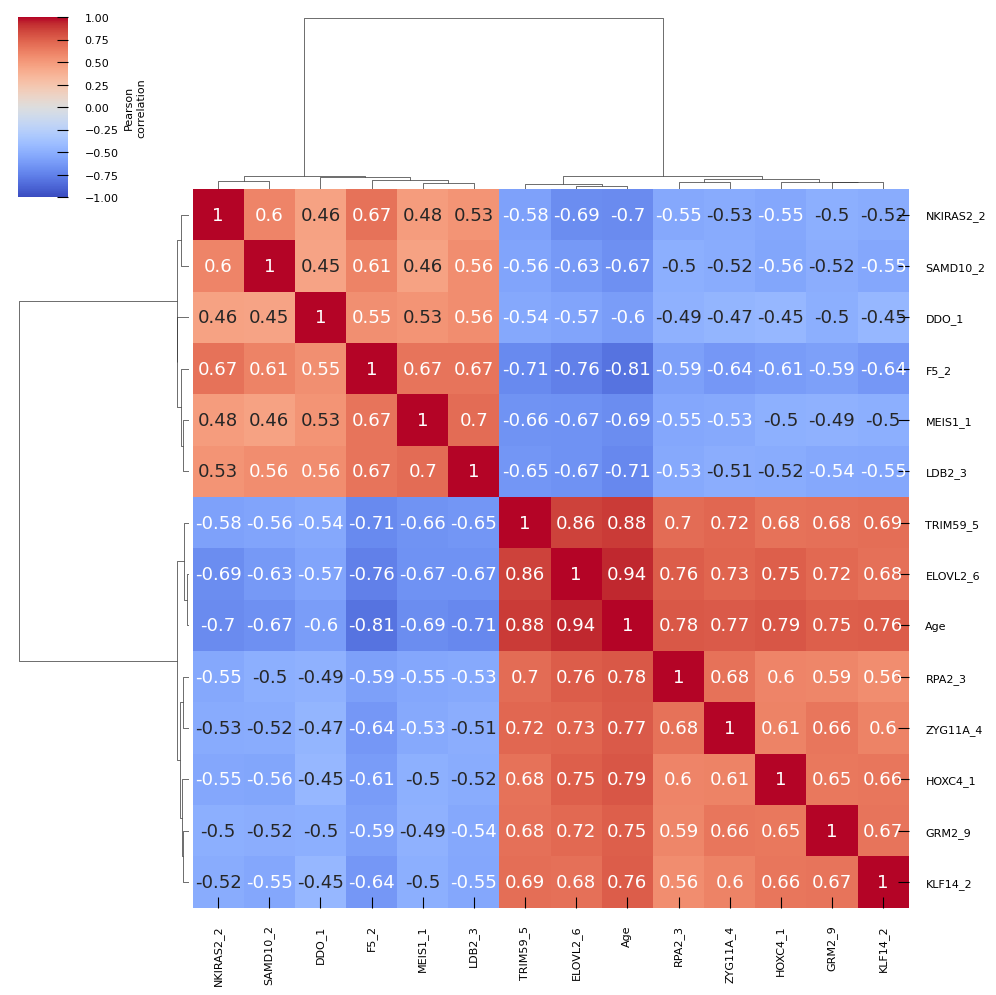

In [181]:
df_meth_corr = df_meth.corr()

sns.clustermap(df_meth_corr,
               figsize=(10,10),
               z_score=None,
               row_cluster=True,
               col_cluster=True,
               method='ward',
               cmap='coolwarm',vmax=1,vmin=-1, 
               annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})
## sns allows you to do a hierarchical clustering that simply
plt.show()

We see that ELOVL2_6 has a very high correlation with age. Perhaps a model with just this marker would be enough?

<Axes: xlabel='ELOVL2_6', ylabel='Age'>

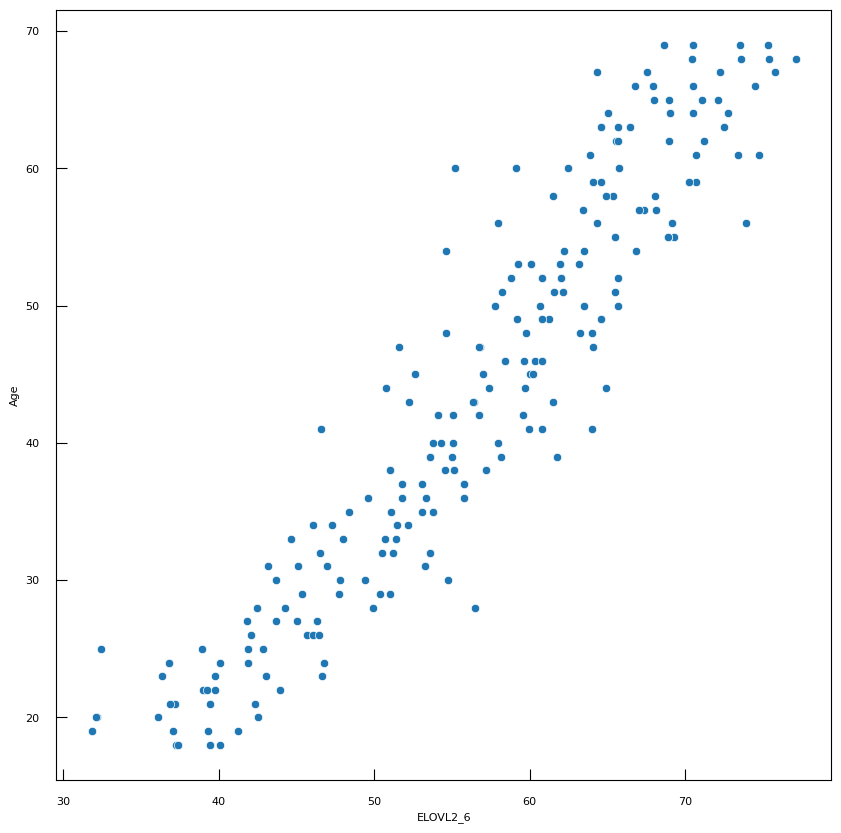

In [182]:
sns.scatterplot(df_meth , x = 'ELOVL2_6' , y = 'Age')

[Back to the ToC](#toc)

# Linear regression <a class="anchor" id="Linear-Regression"></a>

We will start with a reduced dataset for visualization purposes.

In [183]:
from sklearn.model_selection import cross_val_score
X_ELOVL2_6 = X_meth.loc[:,["ELOVL2_6"]]

## to plot nice curves, it is interesting to get an ordered version of X
## points sorted by their values of ELOVL2_6
ELOVL2_6_sorted = X_ELOVL2_6.sort_values(by = "ELOVL2_6")

Here, as we will build a simple linear model with a single feature, we actually have no hyper-parameter at this point.

So we can just build the model with `LinearRegression`:

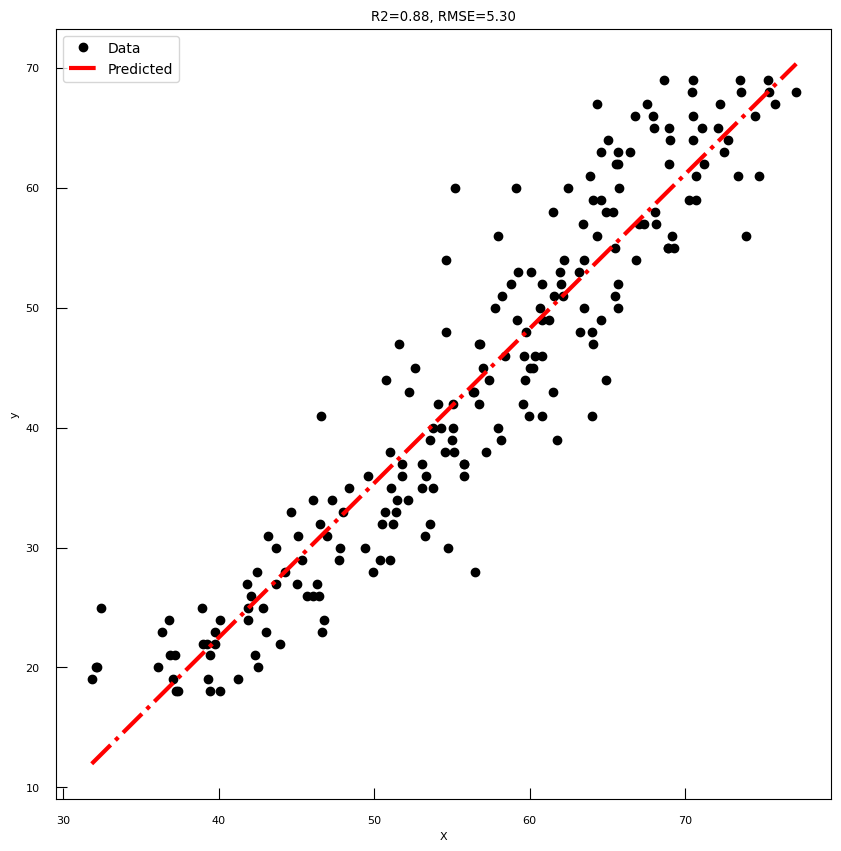

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

## building and fitting model
lr=LinearRegression()
lr.fit(X_ELOVL2_6,y_meth)

## prediction and scoring
y_predict=lr.predict(X_ELOVL2_6)

R2=r2_score(y_meth,y_predict)
RMSE=root_mean_squared_error(y_meth,y_predict)


## plotting

plt.plot(X_ELOVL2_6.ELOVL2_6,y_meth,'ko',label='Data')

plt.plot(ELOVL2_6_sorted.ELOVL2_6, 
         lr.predict( ELOVL2_6_sorted ) ,
         'r-.',label='Predicted', linewidth = 3)

plt.legend(loc='best',fontsize=10)

plt.title('R2={0:.2f}, RMSE={1:.2f}'.format(R2,RMSE))

plt.xlabel('X')
plt.ylabel('y')
plt.show()

If we want to compute a cross-validated score for this simple model we can use `cross_val_score`

In [185]:
from sklearn.model_selection import cross_val_score
cross_val_r2 = cross_val_score( LinearRegression() ,  
                               X_ELOVL2_6 , y_meth , scoring='r2', cv = 5 )

## NB: the built-in scorers want to have a score which should be maximized,
##     so instead of RMSE, it compute negative RMSE
cross_val_RMSE = cross_val_score( LinearRegression() , 
                                 X_ELOVL2_6 , y_meth , scoring='neg_root_mean_squared_error', cv = 5 )

print(f"cross-validated R2: {cross_val_r2.mean():.2f}")
print(f"cross-validated RMSE: {-1 * cross_val_RMSE.mean():.2f}")


cross-validated R2: 0.87
cross-validated RMSE: 5.31


The model seems OK-ish, but if you have some experience with linear models you may see something peculiar.

It becomes more apparent when you look at residuals (ie. error from the model):


Text(0, 0.5, 'residuals')

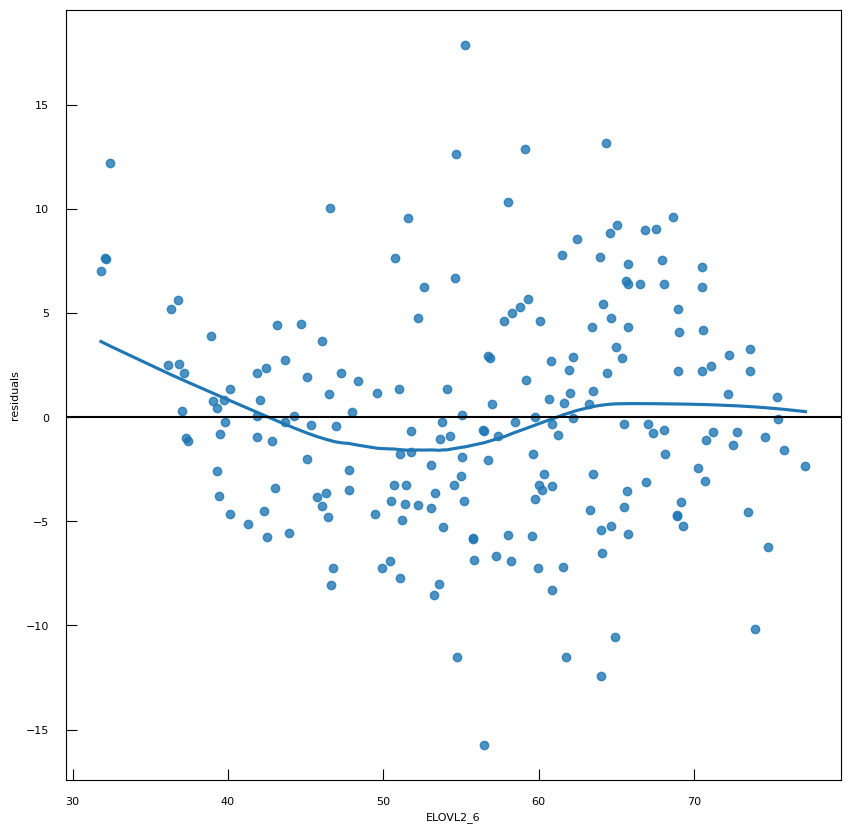

In [186]:
sns.regplot( x = X_ELOVL2_6.ELOVL2_6 , y = residuals , lowess=True)
plt.axhline(y=0, color='black')
plt.ylabel("residuals")

The pattern of residuals may be indicative of a higher order relationship between the marker and age.

But if that's the case, what is an appropriate degree for this model?

degree: 2 - R2=0.88, RMSE=5.22
degree: 3 - R2=0.89, RMSE=5.04
degree: 40 - R2=0.89, RMSE=5.00


Text(0, 0.5, 'age')

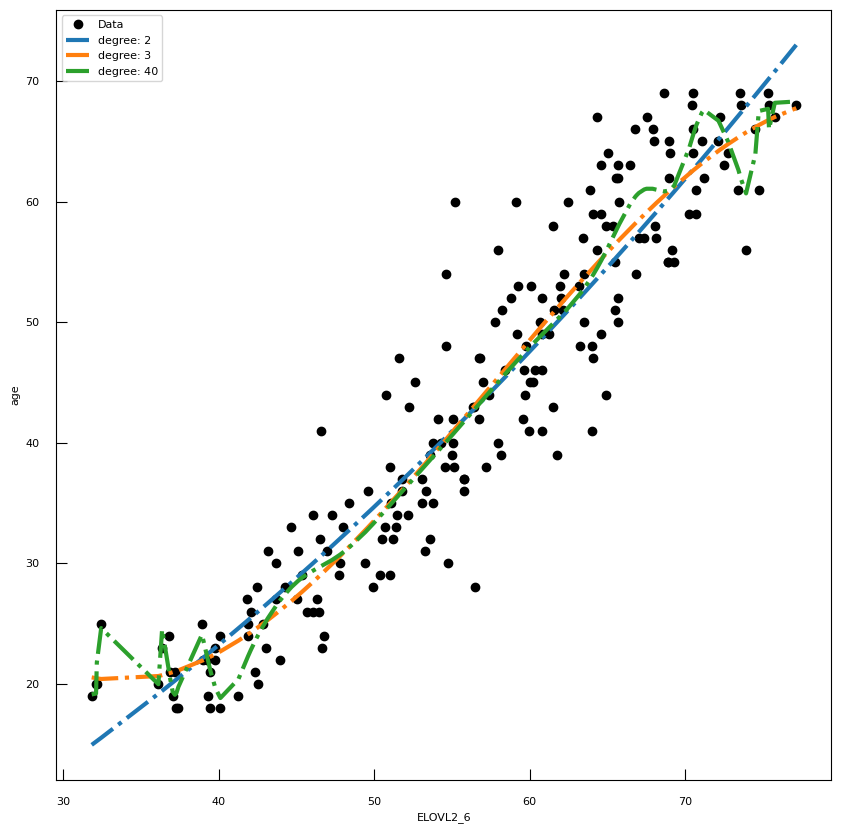

In [203]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

fig,ax = plt.subplots()

## plotting
ax.plot(X_ELOVL2_6.ELOVL2_6,y_meth,'ko',label='Data')

for i,degree in enumerate([2,3,40]):



    X = PolynomialFeatures(degree = degree).fit_transform(StandardScaler().fit_transform(X_ELOVL2_6))
    Xo = PolynomialFeatures(degree = degree).fit_transform(StandardScaler().fit_transform(ELOVL2_6_sorted) )
    y = y_meth 

    lr = LinearRegression()
    lr.fit( X,y )

    ## prediction and scoring
    y_predict=lr.predict(X)

    ax.plot(ELOVL2_6_sorted.ELOVL2_6, 
            lr.predict( Xo ) ,
            '-.',label=f'degree: {degree}', linewidth = 3)

    
    R2=r2_score(y,y_predict)
    RMSE=root_mean_squared_error(y,y_predict)
    
    print(f'degree: {degree} - R2={R2:.2f}, RMSE={RMSE:.2f}')
    
ax.legend(loc='best')
ax.set_xlabel('ELOVL2_6')
ax.set_ylabel('age')



* which degree relationship is appropriate then ?
 * what of the other biomarkers ?

You guessed it, we come back again to hyper-parameters we have to evaluate in order to find the most appropriate model.

In [214]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


pipeline_lr=Pipeline([('scalar',StandardScaler()),
                      ('poly',PolynomialFeatures(include_bias=False)),
                      ('model',LinearRegression())])


# define the hyperparameters you want to test with their range to be tested
grid_values = {'poly__degree': [1,2,3,4,5]}

# Feed them to GridSearchCV with the right score (R squared)
grid_lr = GridSearchCV(pipeline_lr, 
                       param_grid = grid_values, 
                       scoring=['r2','neg_root_mean_squared_error'],
                       refit = 'r2',
                       cv = 5,
                       n_jobs = -1)

grid_lr.fit(X_ELOVL2_6,y_meth)


print(f'Grid best score (r2): {grid_lr.best_score_:.3f}' )
print( 'Grid best parameter (max. r2): ')
for k,v in grid_lr.best_params_.items():
    print( f'\t{k} -> {v}' )

Grid best score (r2): 0.881
Grid best parameter (max. r2): 
	poly__degree -> 3
CPU times: user 68.8 ms, sys: 136 ms, total: 205 ms
Wall time: 1.5 s


In [215]:
df_res = pd.DataFrame( grid_lr.cv_results_ )
df_res[ ["param_poly__degree","mean_test_r2","mean_test_neg_root_mean_squared_error"] ]

,param_poly__degree,mean_test_r2,mean_test_neg_root_mean_squared_error
0,1,0.869974,-5.309843
1,2,0.873178,-5.242462
2,3,0.881085,-5.056111
3,4,0.880842,-5.061832
4,5,0.881014,-5.056687


So it seems that increasing power to 3 increases (at least a bit) our predictive power here.

But what about the other predictors? 



[Back to the ToC](#toc)

## ML approach to linear regression - methylation data <a id='LR-1'></a>

As we add other predictors, it can be good to also add penalization terms.

To enable this we switch from `LinearRegression` to `SGDRegressor` which uses Stochastic Gradient Descent to find the optimal weigths for the penalized score.

In [231]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor


ppl_meth=Pipeline([('scalar',StandardScaler()),
                   ('poly',PolynomialFeatures(include_bias=False)),
                   ('model',SGDRegressor( penalty = 'elasticnet' ))])


# the interaction_only parameter of PolynomialFeature 
# lets us test a case with interaction terms but no higher order terms.
grid_values = {'poly__degree': [1,2,3],
               'poly__interaction_only':[False,True], 
               'model__alpha' : np.logspace( -2,2,20 ),
               'model__l1_ratio' : np.linspace(0.0,1.0,11)
              }

# Feed them to GridSearchCV with the right score (R squared)
grid_meth = GridSearchCV(ppl_meth,
                         param_grid = grid_values, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         refit = 'r2',
                         cv = 5,
                        n_jobs = -1)

grid_meth.fit(X_meth, y_meth)


print(f'Grid best score (grid_meth.scoring): {grid_meth.best_score_:.3f}' )
print( 'Grid best parameter (max. r2): ')
for k,v in grid_meth.best_params_.items():
    print( f'\t{k} -> {v}' )

Grid best score (grid_meth.scoring): 0.936
Grid best parameter (max. r2): 
	model__alpha -> 0.4832930238571752
	model__l1_ratio -> 0.8
	poly__degree -> 2
	poly__interaction_only -> True
CPU times: user 3.92 s, sys: 41.3 ms, total: 3.96 s
Wall time: 15.4 s


In [232]:
poly = grid_meth.best_estimator_['poly']
LR = grid_meth.best_estimator_['model']

def pow2name(power, fnames=X_meth.columns ):
    n = []
    for i,j in enumerate(power):
        if j>0:
            if j == 1:
                n.append( fnames[i] )
            else:
                n.append( fnames[i]+'^'+str(j) )
    return "_x_".join(n)
    
sorted_list=sorted( zip( map( pow2name , poly.powers_) , LR.coef_ ) ,key=itemgetter(1),reverse=True)
print('model importances')
for f,w in sorted_list:
    if w != 0:
        print("{:>30}\t{:.2f}".format(f,w))
    

model importances
                      ELOVL2_6	4.02
                      TRIM59_5	2.28
                       HOXC4_1	1.81
                        RPA2_3	1.80
                        GRM2_9	1.45
                LDB2_3_x_DDO_1	0.70
                      ZYG11A_4	0.58
              MEIS1_1_x_LDB2_3	0.27
           TRIM59_5_x_ELOVL2_6	0.14
            ZYG11A_4_x_KLF14_2	0.06
           NKIRAS2_2_x_KLF14_2	-0.24
                       MEIS1_1	-0.33
                         DDO_1	-0.41
                        LDB2_3	-0.95
                     NKIRAS2_2	-1.01
                          F5_2	-1.88


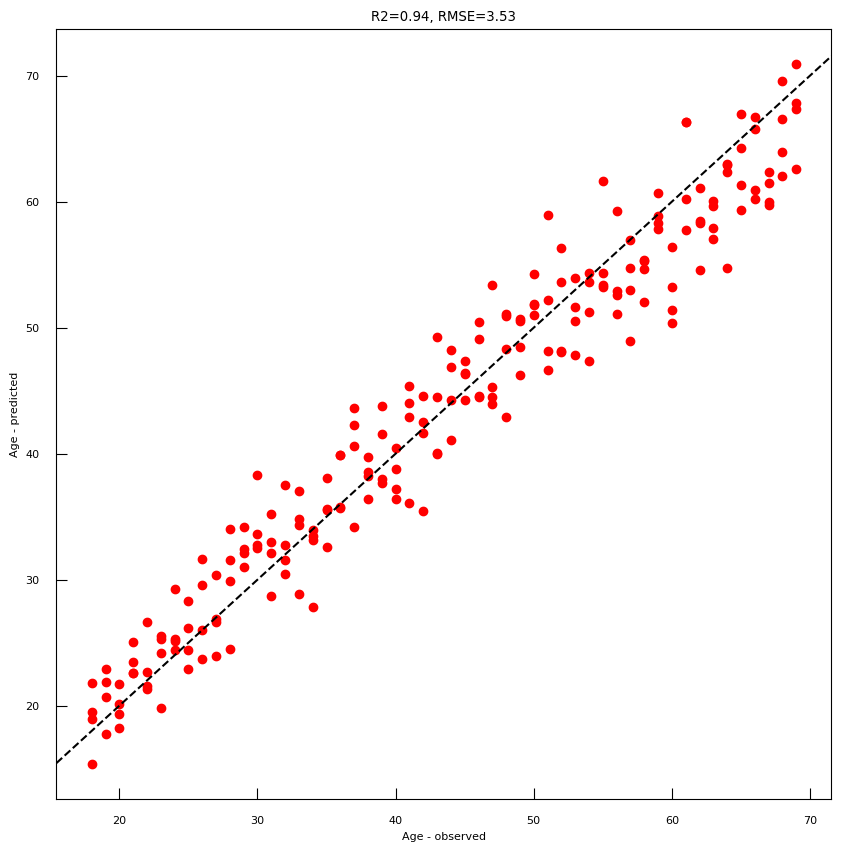

In [233]:
y_predict = grid_meth.best_estimator_.predict( X_meth)

R2=r2_score(y_meth,y_predict)
RMSE=root_mean_squared_error(y_meth,y_predict)


plt.plot(y_meth,y_predict,'ro',label='Predicted', linewidth = 3)
plt.title('R2={0:.2f}, RMSE={1:.2f}'.format(R2,RMSE))
plt.axline((20, 20), slope=1, color="black", linestyle='dashed')
plt.xlabel('Age - observed')
plt.ylabel('Age - predicted')
plt.show()

In [235]:
df_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,param_poly__degree,param_poly__interaction_only,params,split0_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.008661,0.003285,0.003215,0.000094,0.01,0.0,1,False,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0,...",9.093408e-01,...,1.360539e-02,139,-4.056293e+00,-3.935430e+00,-3.434870e+00,-3.781543e+00,-3.883674e+00,-3.818362e+00,2.111888e-01,123
1,0.007518,0.001742,0.003943,0.000954,0.01,0.0,1,True,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0,...",9.079792e-01,...,1.432012e-02,126,-4.086640e+00,-3.947647e+00,-3.385691e+00,-3.797037e+00,-3.849532e+00,-3.813309e+00,2.354528e-01,99
2,0.024718,0.010478,0.003040,0.000616,0.01,0.0,2,False,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0,...",6.811879e-01,...,7.515174e-02,615,-7.606604e+00,-9.299928e+00,-5.835074e+00,-7.910553e+00,-8.210679e+00,-7.772568e+00,1.124743e+00,615
3,0.017608,0.001361,0.004524,0.002844,0.01,0.0,2,True,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0,...",8.843405e-01,...,1.777576e-02,466,-4.581567e+00,-5.590029e+00,-5.044574e+00,-4.415290e+00,-5.274488e+00,-4.981190e+00,4.337435e-01,464
4,0.029247,0.006971,0.036096,0.026581,0.01,0.0,3,False,"{'model__alpha': 0.01, 'model__l1_ratio': 0.0,...",-4.593953e+21,...,1.640260e+21,1095,-9.130964e+11,-1.056255e+12,-1.378792e+12,-8.593480e+11,-9.303482e+11,-1.027568e+12,1.871015e+11,1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.006166,0.000107,0.003039,0.000084,100.00,1.0,1,True,"{'model__alpha': 100.0, 'model__l1_ratio': 1.0...",-4.576521e-02,...,1.800360e-02,843,-1.377655e+01,-1.581029e+01,-1.555045e+01,-1.533973e+01,-1.487537e+01,-1.507048e+01,7.158911e-01,845
1316,0.013815,0.001635,0.002966,0.000180,100.00,1.0,2,False,"{'model__alpha': 100.0, 'model__l1_ratio': 1.0...",-4.537432e-02,...,1.830673e-02,842,-1.377398e+01,-1.581758e+01,-1.554330e+01,-1.533882e+01,-1.487878e+01,-1.507049e+01,7.171329e-01,846
1317,0.013225,0.003000,0.003266,0.000231,100.00,1.0,2,True,"{'model__alpha': 100.0, 'model__l1_ratio': 1.0...",-4.441263e-02,...,1.806021e-02,779,-1.376764e+01,-1.582157e+01,-1.554111e+01,-1.533663e+01,-1.486976e+01,-1.506734e+01,7.202909e-01,779
1318,0.045403,0.001823,0.003490,0.000245,100.00,1.0,3,False,"{'model__alpha': 100.0, 'model__l1_ratio': 1.0...",-4.617296e-02,...,1.826679e-02,796,-1.377924e+01,-1.581348e+01,-1.553918e+01,-1.533947e+01,-1.487274e+01,-1.506882e+01,7.142101e-01,794


In [238]:



df_res = pd.DataFrame(grid_meth.cv_results_)
print("R-squared")
print( df_res.groupby(['param_poly__degree','param_poly__interaction_only'])[ "mean_test_r2" ].max() )

print("neg RMSE")
print( df_res.groupby(['param_poly__degree','param_poly__interaction_only'])["mean_test_neg_root_mean_squared_error"].max())

R-squared
param_poly__degree  param_poly__interaction_only
1                   False                           0.933401
                    True                            0.933445
2                   False                           0.935315
                    True                            0.936271
3                   False                           0.413004
                    True                            0.498708
Name: mean_test_r2, dtype: float64
neg RMSE
param_poly__degree  param_poly__interaction_only
1                   False                           -3.794444
                    True                            -3.795393
2                   False                           -3.753943
                    True                            -3.723698
3                   False                          -11.231821
                    True                           -10.469456
Name: mean_test_neg_root_mean_squared_error, dtype: float64


[Back to the ToC](#toc)

# KNN <a class="anchor" id="KNN"></a>

You can also use the KNN algorithm for regression.
Again you get the K nearest neighbors of the point you want to predict but this time instead of a vote it does a local average of the neighbours value (again weighted or not by their distance to your query point).

In [239]:
from sklearn.neighbors import KNeighborsRegressor
help( KNeighborsRegressor )

Help on class KNeighborsRegressor in module sklearn.neighbors._regression:

class KNeighborsRegressor(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.RegressorMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  .. versionadded:: 0.9
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |

**micro-exercise:** complete the code below to train a KNN regressor model for the methylation data. Optimize the `n_neighbors` and `weights` hyper-parameters:

In [241]:
%%time
from sklearn.neighbors import KNeighborsRegressor


ppl_meth_KNN=Pipeline([('scalar',StandardScaler()),
                   ('poly',PolynomialFeatures(include_bias=False)),
                   ('model', ... )])



grid_values = {'poly__degree': [1,2,3],
               'poly__interaction_only':[False,True], 
               ... ### change things here
              }


grid_meth_KNN = GridSearchCV(ppl_meth_KNN,
                             param_grid = grid_values, 
                             scoring=['r2', 'neg_root_mean_squared_error'],
                             refit = 'r2',
                             cv = 5)

grid_meth_KNN.fit(X_meth, y_meth)


print(f'Grid best score (grid_meth.scoring): {grid_meth_KNN.best_score_:.3f}' )
print( 'Grid best parameter (max. r2): ')
for k,v in grid_meth_KNN.best_params_.items():
    print( f'\t{k} -> {v}' )

Grid best score (grid_meth.scoring): 0.927
Grid best parameter (max. r2): 
	model__n_neighbors -> 8
	model__weights -> distance
	poly__degree -> 1
	poly__interaction_only -> False
CPU times: user 22.8 s, sys: 296 ms, total: 23.1 s
Wall time: 5.9 s


/home/wandrille/Installed_software/anaconda3/envs/introML2024/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning:

invalid value encountered in cast



In [250]:
## getting the corresponding RMSE require some legwork
cv_res = pd.DataFrame( grid_meth_KNN.cv_results_ )
cv_res.loc[ cv_res.rank_test_r2 == 1 , 'mean_test_neg_root_mean_squared_error']

90   -3.983888
91   -3.983888
Name: mean_test_neg_root_mean_squared_error, dtype: float64

So we see that the model we get from KKN is not bad at all **but** the interpretability is lacking in this model.

> KNN regressor is not really good at predicting sparse neigborhoods (the predictions for the extreme data points are not accurate).

<br>

[Back to the ToC](#toc)

<br>

## Random Forest <a class="anchor" id="rf-r"></a>

From the standpoint of tree, the only difference is that now, instead of the entropy or Gini criterion, **the decision which variable to use at any node is made using a regression metric**, such as squared error for example.

For example, consider this example of [regression with a single tree](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html), adapted from the sklearn website:

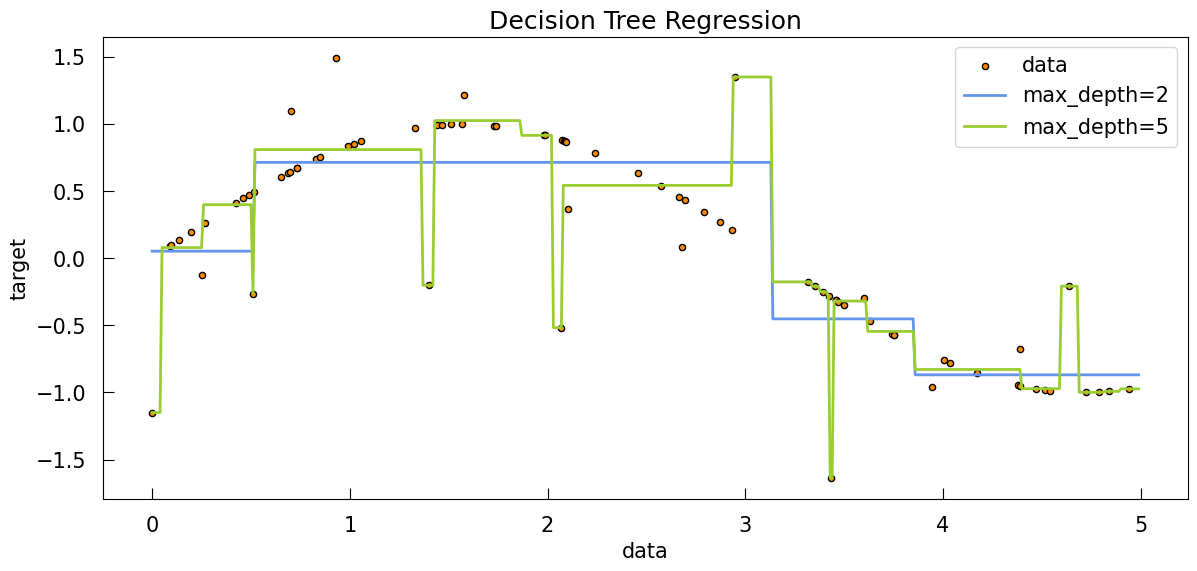

In [28]:
from sklearn.tree import DecisionTreeRegressor
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16)) # adding additional noise to some of the points

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


Text(0.5, 1.0, 'best single decision tree')

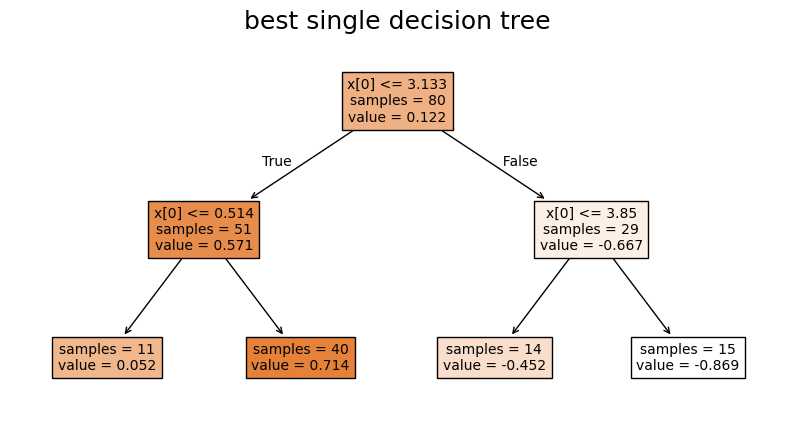

In [29]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(10,5))
plot_tree( regr_1 , 
          ax=ax , fontsize=10 , filled=True , impurity=False , precision=3)
ax.set_title('best single decision tree')

Of course with a single tree you do not get very far, unless the tree becomes absolutely huge. 

But with a random forest you can aggregate the estimate from many trees to get somewhere nice.

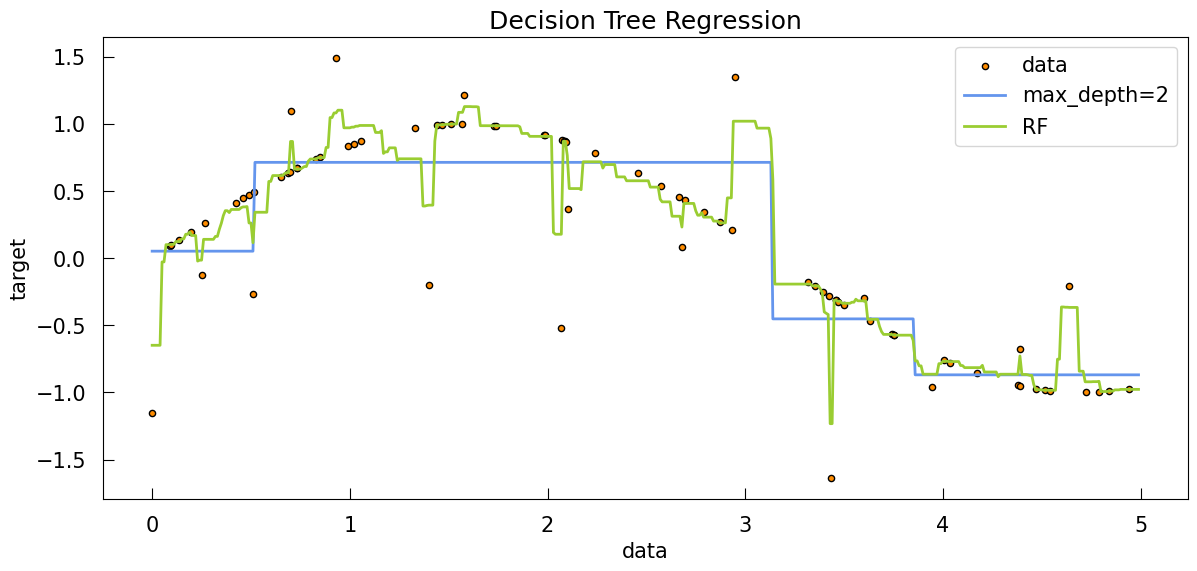

In [30]:
from sklearn.ensemble import RandomForestRegressor

RFReg = RandomForestRegressor(n_estimators=10 )
RFReg.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_rf = RFReg.predict(X_test)

# Plot the results
plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()



With a bit of leg-work, we can even grab the inidividual trees predictions to build an interval around the random forest prediction: 

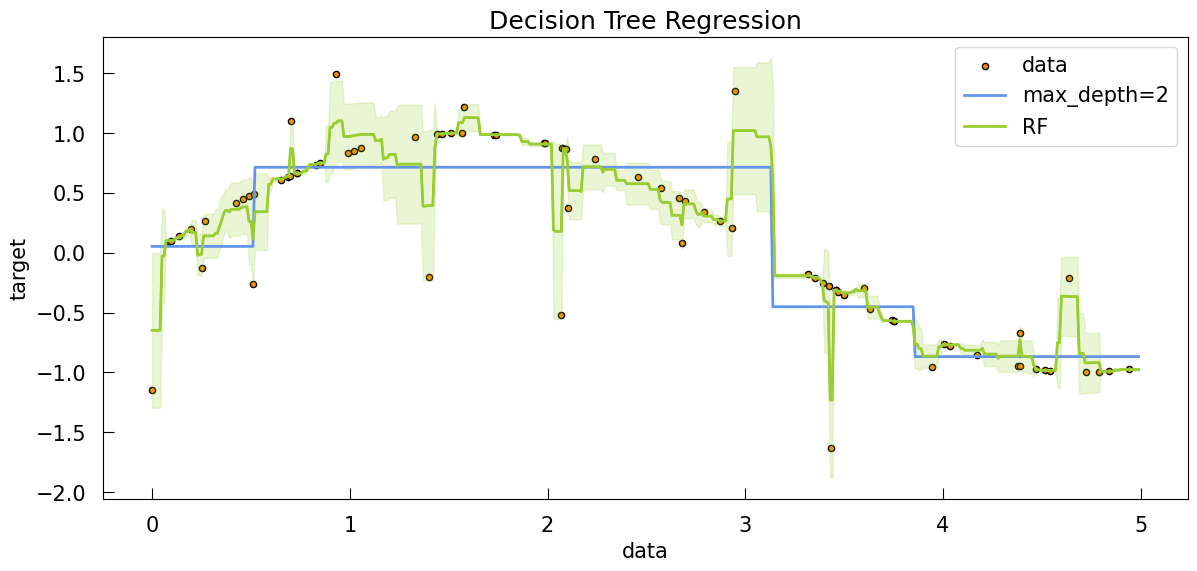

In [31]:

## collecting prediction from all individual trees in a big list
y_pred = []
x_pred = []
for tree in RFReg.estimators_ :
    y_pred += list( tree.predict(X_test) )
    x_pred += list(X_test[:,0])


plt.figure(figsize = (14,6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_rf, color="yellowgreen", label="RF", linewidth=2)
sns.lineplot(x=x_pred , y=y_pred , color="yellowgreen" , errorbar = 'sd') 
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


Let's try on the methylation data:

In [252]:
%%time
from sklearn.ensemble import RandomForestRegressor

## when it comes to criterion, we can now choose:
# * “squared_error” (default) for the mean squared error, minimizes the L2 loss
#                                           using the mean of each terminal node,
# * “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits
# * “absolute_error” for the mean absolute error, which minimizes the L1 loss
#                                           using the median of each terminal node,
# * “poisson” which uses reduction in Poisson deviance to find splits.
#
# let's try squared error and absolute error

grid_values = {'criterion': ['squared_error' , 'absolute_error'],
               'n_estimators':[1000], 
               'max_depth':[6,8,10],
               'min_samples_split':np.arange(2,23,5)}

grid_RF = GridSearchCV(RandomForestRegressor(),
                                param_grid = grid_values, 
                                scoring=['r2', 'neg_root_mean_squared_error'],
                                refit = 'r2',
                                n_jobs=-1,
                                cv=5)

grid_RF.fit(X_meth, y_meth)


print('Grid best score (r2): ', grid_RF.best_score_)
print('Grid best parameter (max. r2): ')

for k,v in grid_RF.best_params_.items():
    print( f'\t{k} -> {v}' )

Grid best score (r2):  0.9134261550759518
Grid best parameter (max. r2): 
	criterion -> absolute_error
	max_depth -> 8
	min_samples_split -> 2
	n_estimators -> 1000
CPU times: user 5.08 s, sys: 89.1 ms, total: 5.17 s
Wall time: 1min 44s


In [259]:
feature_importance=grid_RF.best_estimator_.feature_importances_


sorted_features=sorted( list( zip( X_meth.columns , feature_importance ) ),key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
for f,w in sorted_features:
    print('{:>20}\t{:.3f}'.format(f,w))

Features sorted per importance in discriminative process
            ELOVL2_6	0.681
            TRIM59_5	0.060
                F5_2	0.045
             KLF14_2	0.030
              RPA2_3	0.027
              LDB2_3	0.023
            ZYG11A_4	0.021
              GRM2_9	0.021
             HOXC4_1	0.020
               DDO_1	0.020
           NKIRAS2_2	0.019
            SAMD10_2	0.016
             MEIS1_1	0.016


Tree-based techniques are interesting because:
 * they do not necessitate scaling
 * they give interpretable models and results
 * they model arbitrary non-linear problems
 
However as you have seen they tend to take longer to train...

[Back to ToC](#toc)

# Exercise:  <a class="anchor" id="exo"></a>

We go back to the potato dataset we introduced in notebook 3.

> the model can take even longer than before to train. Be mindful of the parameter space you specify. For instance, if you use a polynomial : do you really want a 3rd degree polynomial exploring all combinations of 15000 genes ? How many parameters would that represent?
 Again, `SelectKBest`, and/or a preliminary PCA are your friend (use scores adapted to regression)

Try linear regression (with different degrees if you wish) and gradient boosting tree. What do you learn about Flesh Color?

In [260]:
file_metadata = "../data/potato_data.phenotypic.csv"
file_data = "../data/potato_data.transcriptomic.top200norm.csv"

df = pd.read_csv( file_metadata , index_col=0 )
dfTT = pd.read_csv( file_data , index_col=0)

X = dfTT
X.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Genotype,,,,,,,,,,,,,,,,,,,,,
CE017,0.086271,-0.790631,-0.445972,0.788895,0.510650,0.626438,0.829346,0.432200,-1.344748,1.794652,...,-0.754008,-0.013125,0.852473,1.067286,0.877670,0.537247,1.251427,1.052070,-0.135479,-0.526788
CE069,-0.540687,0.169014,0.282120,-1.107200,-1.200370,0.518986,1.027663,-0.374142,-0.937715,1.488139,...,-0.237367,0.684905,1.460319,-1.570253,0.547969,0.635307,0.257955,1.043724,0.733218,-1.768250
CE072,-1.713273,-1.400956,-1.543058,-0.930367,-1.058800,-0.455020,-1.302403,-0.110293,-0.332380,-0.232460,...,-0.131733,-0.070336,0.821996,-1.566652,0.914053,-1.707726,0.498226,-1.500588,0.361168,-1.020456
CE084,-0.096239,-0.599251,-1.499636,-0.847275,-1.171365,-0.952574,-1.347691,0.561542,-0.335009,-0.702851,...,-0.729461,0.135614,1.074398,0.629679,-0.691100,-1.247779,0.167965,-1.525064,0.150271,0.105746
CE110,-0.712374,-1.081618,-1.530316,-1.259747,-1.109999,-0.582357,-1.233085,0.008014,-0.915632,-0.746339,...,-0.054882,0.363344,0.720155,0.465315,1.450199,-1.706606,0.602451,-1.507727,-2.207455,-0.139036


In [261]:
y = df["Flesh Colour"]
y.describe()

count    86.000000
mean     24.054824
std      13.023169
min       6.887500
25%      12.664600
50%      24.278800
75%      31.305050
max      57.035100
Name: Flesh Colour, dtype: float64

separate train and test sets

In [292]:
# %load -r 1-6 solutions/solution_04_potato.py

finding the best linear model

In [291]:
# %load -r 8-36 solutions/solution_04_potato.py

finding the best KNN

In [290]:
# %load -r 37-63 solutions/solution_04_potato.py

finding the best random forest

In [289]:
# %load -r 64-85 solutions/solution_04_potato.py

choosing the best method 

In [288]:
# %load -r 86-90 solutions/solution_04_potato.py

In [287]:
# %load -r 91-105 solutions/solution_04_potato.py

# Extra exercise

You can attempt the same thing with the AML dataset we used in the unsupervised learning:

In [45]:
df_aml=pd.read_excel('../data/gene_drug_sens.xlsx')
X_aml=df_aml[df_aml.columns[9:]] 
y_aml = df_aml.auc #  <-- this is the target metric
X_aml.head()

,CD86,FAM49A,ERMN,CHD5,RP11-333E13.2,KLHDC3,HNMT,ADAP2,B3GNT2,RP11-196G18.24,TLR2,MIR223,RAB43P1,GYPC,HSD17B13,HNRNPA1,NAPSB
0,-1.120073,-0.148654,-1.579624,-0.756073,0.471452,1.068268,-0.157964,-1.001751,1.556003,-1.608982,0.751515,0.987769,0.232332,0.981147,-2.021119,-1.185687,-0.710025
1,2.498957,-1.015880,-0.859471,-0.555560,-0.142550,-0.161521,2.279642,-0.933841,-0.189892,0.313041,2.097701,-1.627445,-0.961402,-0.523684,0.255906,0.885343,0.900553
2,0.176687,-0.490400,-0.611194,-0.443875,0.876031,-0.147330,0.112438,-0.185127,0.235198,-1.389968,0.007096,1.291810,-0.504791,0.813038,-0.741312,-1.180863,-2.541507
3,0.918236,0.377131,-0.410336,-0.033461,-0.014791,1.218267,1.122505,-0.333728,0.038227,-0.187054,-0.376509,0.826023,0.847269,-0.466044,0.374157,0.585562,-0.747859
4,-1.004299,-0.826399,0.995739,-1.426430,-0.053345,0.585897,-0.876732,0.564804,-0.835560,-0.566891,0.546441,-0.371254,1.609191,0.220240,-2.180800,1.076900,0.411095


[Back to ToC](#toc)

# Appendices <a class="anchor" id="APPENDIX"></a>

[Back to the ToC](#toc)

# SVM <a class="anchor" id="SVM"></a>

In SVM regression the algo is almost the same as classifier SVM with one big difference. In classification we were looking at the hyperplane that was as far as possible from our support vectors.
In regression you look for the **hyperplanes that are as close as possible from your support vector**.

> NB: **Support vectors** are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. 


In [46]:
from sklearn.svm import SVR

svr=SVR()

pipeline_svr=Pipeline([('scalar',StandardScaler()),('model',svr)])

from sklearn.model_selection import GridSearchCV

# define the hyperparameters you want to test with their range
# kernel: kernel type to be used in the algorithm (function that takes low dimensional input space 
# and transforms it to a higher dimensional space)
# degree: degree of the polynomial kernel function
# epsilon: parameters that controls which data points contribute to regularization
# C: inverse of regularization strength
grid_values = [{"model": [SVR(kernel='linear')],
                 "model__C":np.logspace(-2, 2, 10)},
                {"model": [SVR(kernel='rbf')],
                 "model__gamma": np.logspace(-2,1,10)},
                {"model": [SVR(kernel='poly')],
                 "model__C":np.logspace(-2, 2, 10),
                 "model__degree":np.arange(2,10,1)}]

# Feed them to GridSearchCV with the right score (R squared)
grid_svr_acc = GridSearchCV(pipeline_svr, param_grid = grid_values, scoring='r2')

grid_svr_acc.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores_acc=grid_svr_acc.score(X_diabetes_test,y_diabetes_test)


print('Grid best parameter (max. r2): ', grid_svr_acc.best_params_)
print('Grid best score (r2): ', grid_svr_acc.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores_acc)

Grid best parameter (max. r2):  {'model': SVR(kernel='linear'), 'model__C': np.float64(1.6681005372000592)}
Grid best score (r2):  0.46396630381267734
Grid best parameter (max. r2) model on test:  0.5519849098247016


In [47]:
best_kernel = grid_svr_acc.best_estimator_.steps[1][1].kernel
if best_kernel=='linear':
    
    svr = grid_svr_acc.best_estimator_.steps[1][1]
    
    featureW = pd.DataFrame( {'feature' : diabetes['feature_names'],
                                'weight': svr.coef_.flatten()} )

    # sort them by absolute value
    featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

    # get the non-null ones
    print('Features sorted per importance:')
    print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )

    

Features sorted per importance:
  feature     weight
2     bmi  22.730273
8      s5  21.056282
3      bp  19.255008
1     sex -14.743769
6      s3 -10.238319
5      s2  -6.598145
4      s1  -4.368385
9      s6   3.733290
7      s4   3.226927
0     age  -1.698126


[Back to the ToC](#toc)

# Gradient boosting tree <a class="anchor" id="Gradient"></a>

Gradient boosted is made for regression (you saw that already)! It is even simpler than what we saw before since you don't have to do all those transformations and just go for minimizing the MSE loss function. So let's check it out.

In [48]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

# define the hyperparameters you want to test with their range
grid_values = {'learning_rate':np.logspace(-1,0,5),
               'n_estimators':np.arange(25,101,25), 
               'max_depth':[2,3,4],
               'min_samples_split':[10,20],
               'min_samples_leaf':[2,5]}

# Feed them to GridSearchCV with the right score (R squared)
grid_tree = GridSearchCV(GradientBoostingRegressor(), param_grid = grid_values, scoring='r2')

grid_tree.fit(X_diabetes_train, y_diabetes_train)

y_decision_fn_scores=grid_tree.score(X_diabetes_test,y_diabetes_test)


print('Grid best parameter (max. r2): ', grid_tree.best_params_)
print('Grid best score (r2): ', grid_tree.best_score_)
print('Grid best parameter (max. r2) model on test: ', y_decision_fn_scores)

Grid best parameter (max. r2):  {'learning_rate': np.float64(0.1778279410038923), 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': np.int64(25)}
Grid best score (r2):  0.4284555081857044
Grid best parameter (max. r2) model on test:  0.5380192947311326
CPU times: user 1min 56s, sys: 322 ms, total: 1min 56s
Wall time: 2min 25s


In [49]:
RFC = grid_tree.best_estimator_
    
featureW = pd.DataFrame( {'feature': diabetes['feature_names'],
                        'weight':RFC.feature_importances_} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )

Features sorted per importance:
  feature    weight
2     bmi  0.373461
8      s5  0.366582
3      bp  0.117270
6      s3  0.048118
9      s6  0.027981
0     age  0.018402
5      s2  0.018329
4      s1  0.017458
1     sex  0.012398
